In [1]:
# Imports
import torch
import numpy as np
import random

# Causal_cocycle imports
from causal_cocycle.model_factory import CocycleFactory
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.optimise_new import validate, optimise
from causal_cocycle.kernels import gaussian_kernel
from causal_cocycle.helper_functions import kolmogorov_distance

# Import the DGP and policy functions from BD.py
from BD import DGP, policy, new_policy

# Import configs 
from BD_cocycle_config_debug import model_config, opt_config
from BD_dgp_config import dgp_config

import matplotlib.pyplot as plt

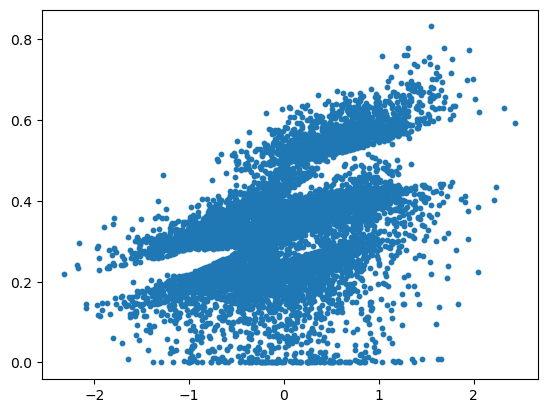

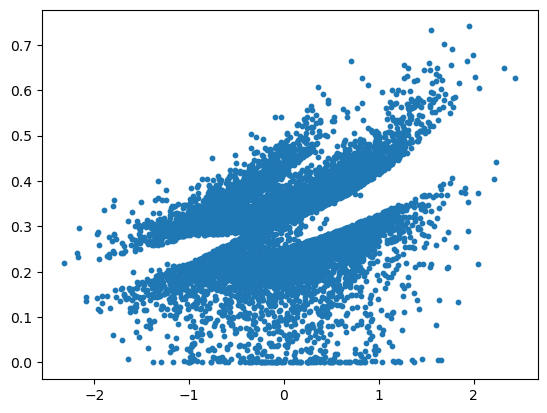

In [2]:
# Generating observatioanl data with configs
seed = 0
N = int(dgp_config['N']/2)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Z,X,Y = DGP(policy = policy,**dgp_config)
Z1,X1,Y1 = Z[:N], X[:N],Y[:N]
Z2,X2,Y2 = Z[N:], X[N:],Y[N:]
plt.scatter(Z @ dgp_config['projection_coeffs'],torch.log(1+torch.exp(-Y)), s = 10);
plt.show()

# Generating interventional data with configs
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
Zint,Xint,Yint = DGP(policy = new_policy,**dgp_config)
Zint1,Xint1,Yint1 = Zint[:N], Xint[:N],Yint[:N]
Zint2,Xint2,Yint2 = Zint[N:], Xint[N:],Yint[N:]
plt.scatter(Zint @ dgp_config['projection_coeffs'],torch.log(1+torch.exp(-Yint)), s = 10);

# Random dataset shuffle
id = torch.randperm(Z.size(0))
Ztr,Xtr,Ytr = Z[id],X[id],Y[id]

In [3]:
# Cocycle model construction
input_dim = dgp_config['D']
factory = CocycleFactory(input_dim+1, model_config)
models, hyper_args = factory.build_models()
print(f"Constructed {len(models)} candidate models.")

Constructed 1 candidate models.


In [4]:
# Cocycle loss construction
kernel = [gaussian_kernel()] * 2
loss_factory = CocycleLossFactory(kernel)
loss= loss_factory.build_loss("CMMD_V", X, Y, subsamples=10**4)

In [ ]:
# 1. Best overall model (choose one candidate based on average CV loss, then retrain on full training set)
final_model_overall, val_loss_overall = validate(
    models, 
    loss, 
    Xtr, Ytr,
    loss_val=loss,
    method="fixed",
    train_val_split=1.0,  # 2-fold CV: 50% training per fold.
    opt_kwargs=opt_config,
    hyper_kwargs=hyper_args,
    choose_best_model="overall",
    retrain=False
)
print(f"Best overall model validation loss: {val_loss_overall:.4f}")

Epoch 1/100, Training Loss: -0.5135
Epoch 2/100, Training Loss: -0.5369
Epoch 3/100, Training Loss: -0.5382
Epoch 4/100, Training Loss: -0.5522
Epoch 5/100, Training Loss: -0.5621
Epoch 6/100, Training Loss: -0.5623
Epoch 7/100, Training Loss: -0.5621
Epoch 8/100, Training Loss: -0.5674
Epoch 9/100, Training Loss: -0.5698
Epoch 10/100, Training Loss: -0.5686
Epoch 11/100, Training Loss: -0.5645
Epoch 12/100, Training Loss: -0.5723
Epoch 13/100, Training Loss: -0.5673
Epoch 14/100, Training Loss: -0.5720
Epoch 15/100, Training Loss: -0.5742
Epoch 16/100, Training Loss: -0.5810
Epoch 17/100, Training Loss: -0.5799
Epoch 18/100, Training Loss: -0.5750
Epoch 19/100, Training Loss: -0.5753
Epoch 20/100, Training Loss: -0.5768
Epoch 21/100, Training Loss: -0.5852
Epoch 22/100, Training Loss: -0.5843
Epoch 23/100, Training Loss: -0.5893
Epoch 24/100, Training Loss: -0.5812
Epoch 25/100, Training Loss: -0.5875
Epoch 26/100, Training Loss: -0.5953
Epoch 27/100, Training Loss: -0.5901
Epoch 28/1

In [6]:
# 2. Best model per fold (select one candidate per fold without retraining)
final_models_per_fold, val_loss_per_fold = validate(
    models, 
    loss, 
    Xtr, Ytr,
    loss_val=loss,
    method="CV",
    train_val_split=0.5,
    opt_kwargs=opt_config,
    hyper_kwargs=hyper_args,
    choose_best_model="per fold",
    retrain=False
)
print(f"Best per-fold model validation losses: {val_loss_per_fold}")

Epoch 1/100, Training Loss: -0.5088
Epoch 2/100, Training Loss: -0.5404
Epoch 3/100, Training Loss: -0.5380
Epoch 4/100, Training Loss: -0.5508
Epoch 5/100, Training Loss: -0.5700
Epoch 6/100, Training Loss: -0.5604
Epoch 7/100, Training Loss: -0.5605
Epoch 8/100, Training Loss: -0.5742
Epoch 9/100, Training Loss: -0.5809
Epoch 10/100, Training Loss: -0.5754
Epoch 11/100, Training Loss: -0.5831
Epoch 12/100, Training Loss: -0.5754
Epoch 13/100, Training Loss: -0.5828
Epoch 14/100, Training Loss: -0.5834
Epoch 15/100, Training Loss: -0.5909
Epoch 16/100, Training Loss: -0.5785
Epoch 17/100, Training Loss: -0.5916
Epoch 18/100, Training Loss: -0.5923
Epoch 19/100, Training Loss: -0.5826
Epoch 20/100, Training Loss: -0.5985
Epoch 21/100, Training Loss: -0.5910
Epoch 22/100, Training Loss: -0.5931
Epoch 23/100, Training Loss: -0.5902
Epoch 24/100, Training Loss: -0.5891
Epoch 25/100, Training Loss: -0.5968
Epoch 26/100, Training Loss: -0.5940
Epoch 27/100, Training Loss: -0.6003
Epoch 28/1

In [18]:
# 3. Best overall model per treatment value (choose one candidate based on average CV loss, then retrain on full training set)
opt_config['val_batch_size'] = 512
Xtr1, Ytr1 = Xtr[Xtr[:,0]==1], Ytr[Xtr[:,0]==1]
Xtr2, Ytr2 = Xtr[Xtr[:,0]==2], Ytr[Xtr[:,0]==2]
final_model_overall1, val_loss_overall1 = validate(
    models, 
    loss, 
    Xtr1, Ytr1,
    loss_val=loss,
    method="fixed",
    train_val_split=0.8,  # 2-fold CV: 50% training per fold.
    opt_kwargs=opt_config,
    hyper_kwargs=hyper_args,
    choose_best_model="overall",
    retrain=True
)
print(f"Best overall model (D=1) validation loss: {val_loss_overall:.4f}")
opt_config['val_batch_size'] = 256
final_model_overall2, val_loss_overall2 = validate(
    models, 
    loss, 
    Xtr2, Ytr2,
    loss_val=loss,
    method="fixed",
    train_val_split=0.8,  # 2-fold CV: 50% training per fold.
    opt_kwargs=opt_config,
    hyper_kwargs=hyper_args,
    choose_best_model="overall",
    retrain=True
)
print(f"Best overall model (D=2) validation loss: {val_loss_overall:.4f}")

Epoch 1/100, Training Loss: -0.5575
Epoch 2/100, Training Loss: -0.5800
Epoch 3/100, Training Loss: -0.5806
Epoch 4/100, Training Loss: -0.5783
Epoch 5/100, Training Loss: -0.5860
Epoch 6/100, Training Loss: -0.5797
Epoch 7/100, Training Loss: -0.5819
Epoch 8/100, Training Loss: -0.5980
Epoch 9/100, Training Loss: -0.5916
Epoch 10/100, Training Loss: -0.6010
Epoch 11/100, Training Loss: -0.5971
Epoch 12/100, Training Loss: -0.5999
Epoch 13/100, Training Loss: -0.5948
Epoch 14/100, Training Loss: -0.6018
Epoch 15/100, Training Loss: -0.6057
Epoch 16/100, Training Loss: -0.6249
Epoch 17/100, Training Loss: -0.6184
Epoch 18/100, Training Loss: -0.6128
Epoch 19/100, Training Loss: -0.6009
Epoch 20/100, Training Loss: -0.6063
Epoch 21/100, Training Loss: -0.6070
Epoch 22/100, Training Loss: -0.6210
Epoch 23/100, Training Loss: -0.6115
Epoch 24/100, Training Loss: -0.6073
Epoch 25/100, Training Loss: -0.6121
Epoch 26/100, Training Loss: -0.6115
Epoch 27/100, Training Loss: -0.6213
Epoch 28/1

ZeroDivisionError: float division by zero

In [38]:
def match_quantiles_diff(X, Y):
    """
    Matches quantiles between two sets of points with possibly differing sizes.
    This implements a KR transport in the sense that for each point in Y,
    we assign the X value corresponding to its quantile rank (using ceiling).

    Parameters:
    -----------
    X : torch.Tensor
        1D tensor of values from which quantiles will be taken (target measure).
    Y : torch.Tensor
        1D tensor of values whose quantile ordering is used (source measure).

    Returns:
    --------
    matched_X : torch.Tensor
        Tensor of the same shape as Y, where each element is the value from X 
        corresponding to the quantile rank of Y.
    """
    n_X = X.numel()
    n_Y = Y.numel()
    
    # Sort X to get the quantile values.
    sorted_X, _ = torch.sort(X)
    
    # Compute the empirical quantile for each Y.
    # First, get the order of Y.
    order_Y = torch.argsort(Y)
    # Create a tensor of quantiles from 0 to 1 for the sorted Y.
    if n_Y > 1:
        quantiles = torch.linspace(0, 1, steps=n_Y, device=Y.device)
    else:
        quantiles = torch.tensor([0.5], device=Y.device)
    # Map these quantiles back to the original order.
    p = torch.empty_like(Y, dtype=torch.float)
    p[order_Y] = quantiles

    # Compute the corresponding index in sorted_X using ceiling.
    # Multiply p by (n_X - 1) so that p=1 maps exactly to the last index.
    indices = torch.ceil(p * (n_X - 1)).long()
    indices = torch.clamp(indices, 0, n_X - 1)
    
    # Return the matched X values.
    matched_X = sorted_X[indices]
    return matched_X

# Example usage:
x = torch.tensor([5, 2, 8, 1])         # 4 points
y = torch.tensor([30, 10, 50, 20, 40])   # 5 points

matched = match_quantiles_diff(x, y)
print("Original Y:", x)
print("Matched X quantiles:", matched)


Original Y: tensor([5, 2, 8, 1])
Matched X quantiles: tensor([5, 1, 8, 2, 8])


In [49]:
# Predicting counterfactuals+differences
def feature(y):
    return torch.log(1+torch.exp(-y))

Yint1pred = final_models_per_fold[1].cocycle(Xint1,X1,Y1).detach()
Yint2pred = final_models_per_fold[0].cocycle(Xint2,X2,Y2).detach()
Yintpred_split = torch.concatenate((Yint1pred,Yint2pred))
Yintpred = final_model_overall.cocycle(Xint,X,Y).detach()

Upred1 = final_model_overall1.inverse_transformation(X[X[:,0]==1], Y[X[:,0]==1])
Upred2 = final_model_overall2.inverse_transformation(X[X[:,0]==2], Y[X[:,0]==2])
Upredint = match_quantiles_diff(Upred1[:,0],Upred2[:,0])[:,None]
Yintpred_T = final_model_overall1.transformation(Xint[X[:,0]==2], Upredint)

counterfactual_diffs = feature(Yint[X[:,0]==2])-feature(Y[X[:,0]==2])
counterfactual_diffpreds = feature(Yintpred[X[:,0]==2])-feature(Y[X[:,0]==2])
counterfactual_diffpreds_split = feature(Yintpred_split[X[:,0]==2])-feature(Y[X[:,0]==2])
counterfactual_diffpreds_T = feature(Yintpred_T)-feature(Y[X[:,0]==2])

In [50]:
(((counterfactual_diffs - counterfactual_diffpreds_split).abs()**2).mean()**0.5,
((counterfactual_diffs - counterfactual_diffpreds).abs()**2).mean()**0.5,
((counterfactual_diffs - counterfactual_diffpreds_T).abs()**2).mean()**0.5)

(tensor(0.0316), tensor(0.0295), tensor(0.0465, grad_fn=<PowBackward0>))

In [54]:
counterfactual_diffpreds_T.shape

torch.Size([2528, 1])

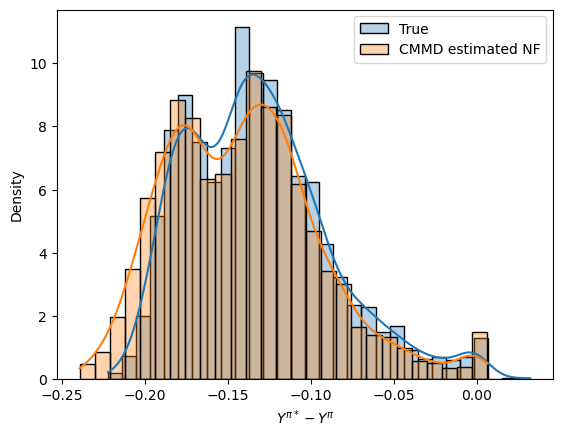

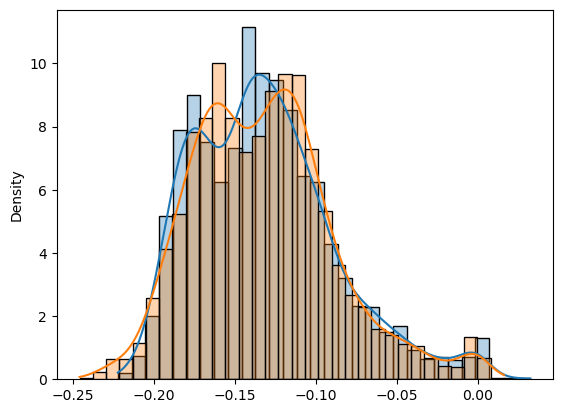

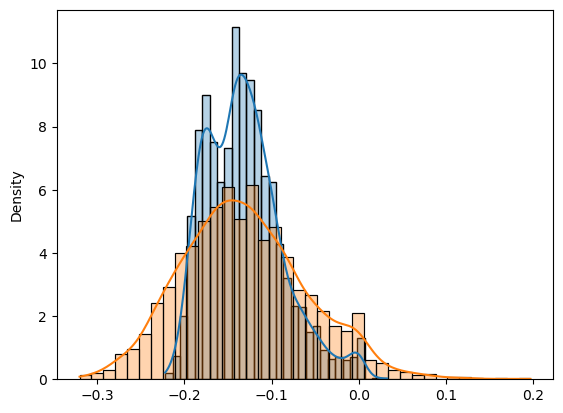

In [55]:
import seaborn as sns
fig, ax = plt.subplots()
sns.histplot(counterfactual_diffs[:,0], alpha=0.33, stat = "density", kde = True, label = "True")
sns.histplot(counterfactual_diffpreds[:,0], alpha=0.33, stat = "density", kde = True, label = "CMMD estimated NF")
plt.xlabel(r"$Y^{\pi*} - Y^\pi$")
plt.legend()
fig.savefig("counterfactual_dist_bd_cocycles")
plt.show()

sns.histplot(counterfactual_diffs[:,0],alpha=0.33, stat = "density", kde = True)
sns.histplot(counterfactual_diffpreds_split[:,0],  alpha=0.33, stat = "density", kde = True)
plt.show()


sns.histplot(counterfactual_diffs[:,0],alpha=0.33, stat = "density", kde = True)
sns.histplot(counterfactual_diffpreds_T[:,0].detach(),  alpha=0.33, stat = "density", kde = True)
plt.show()

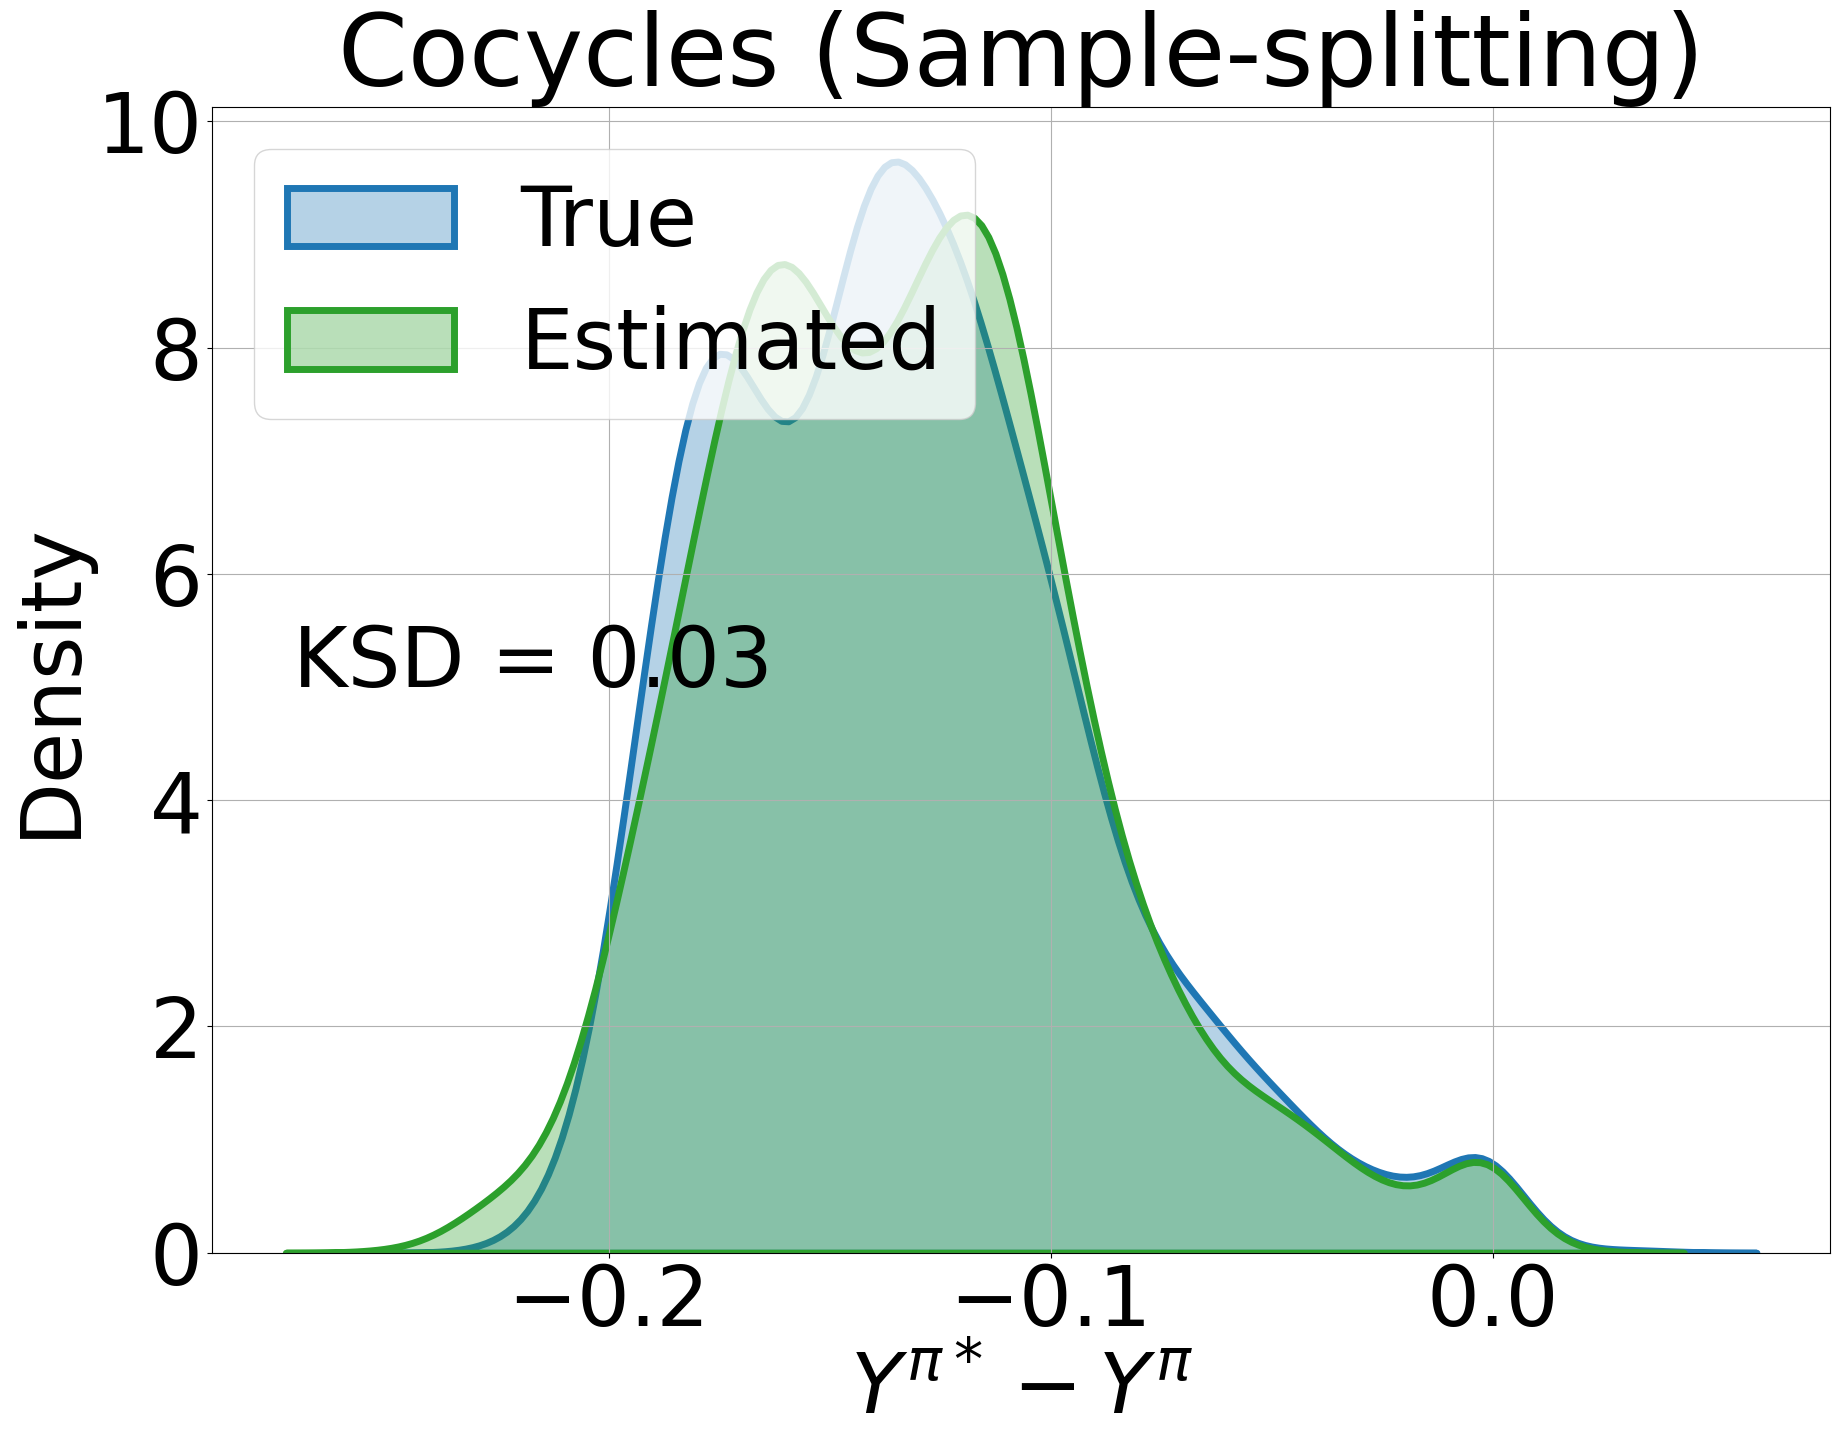

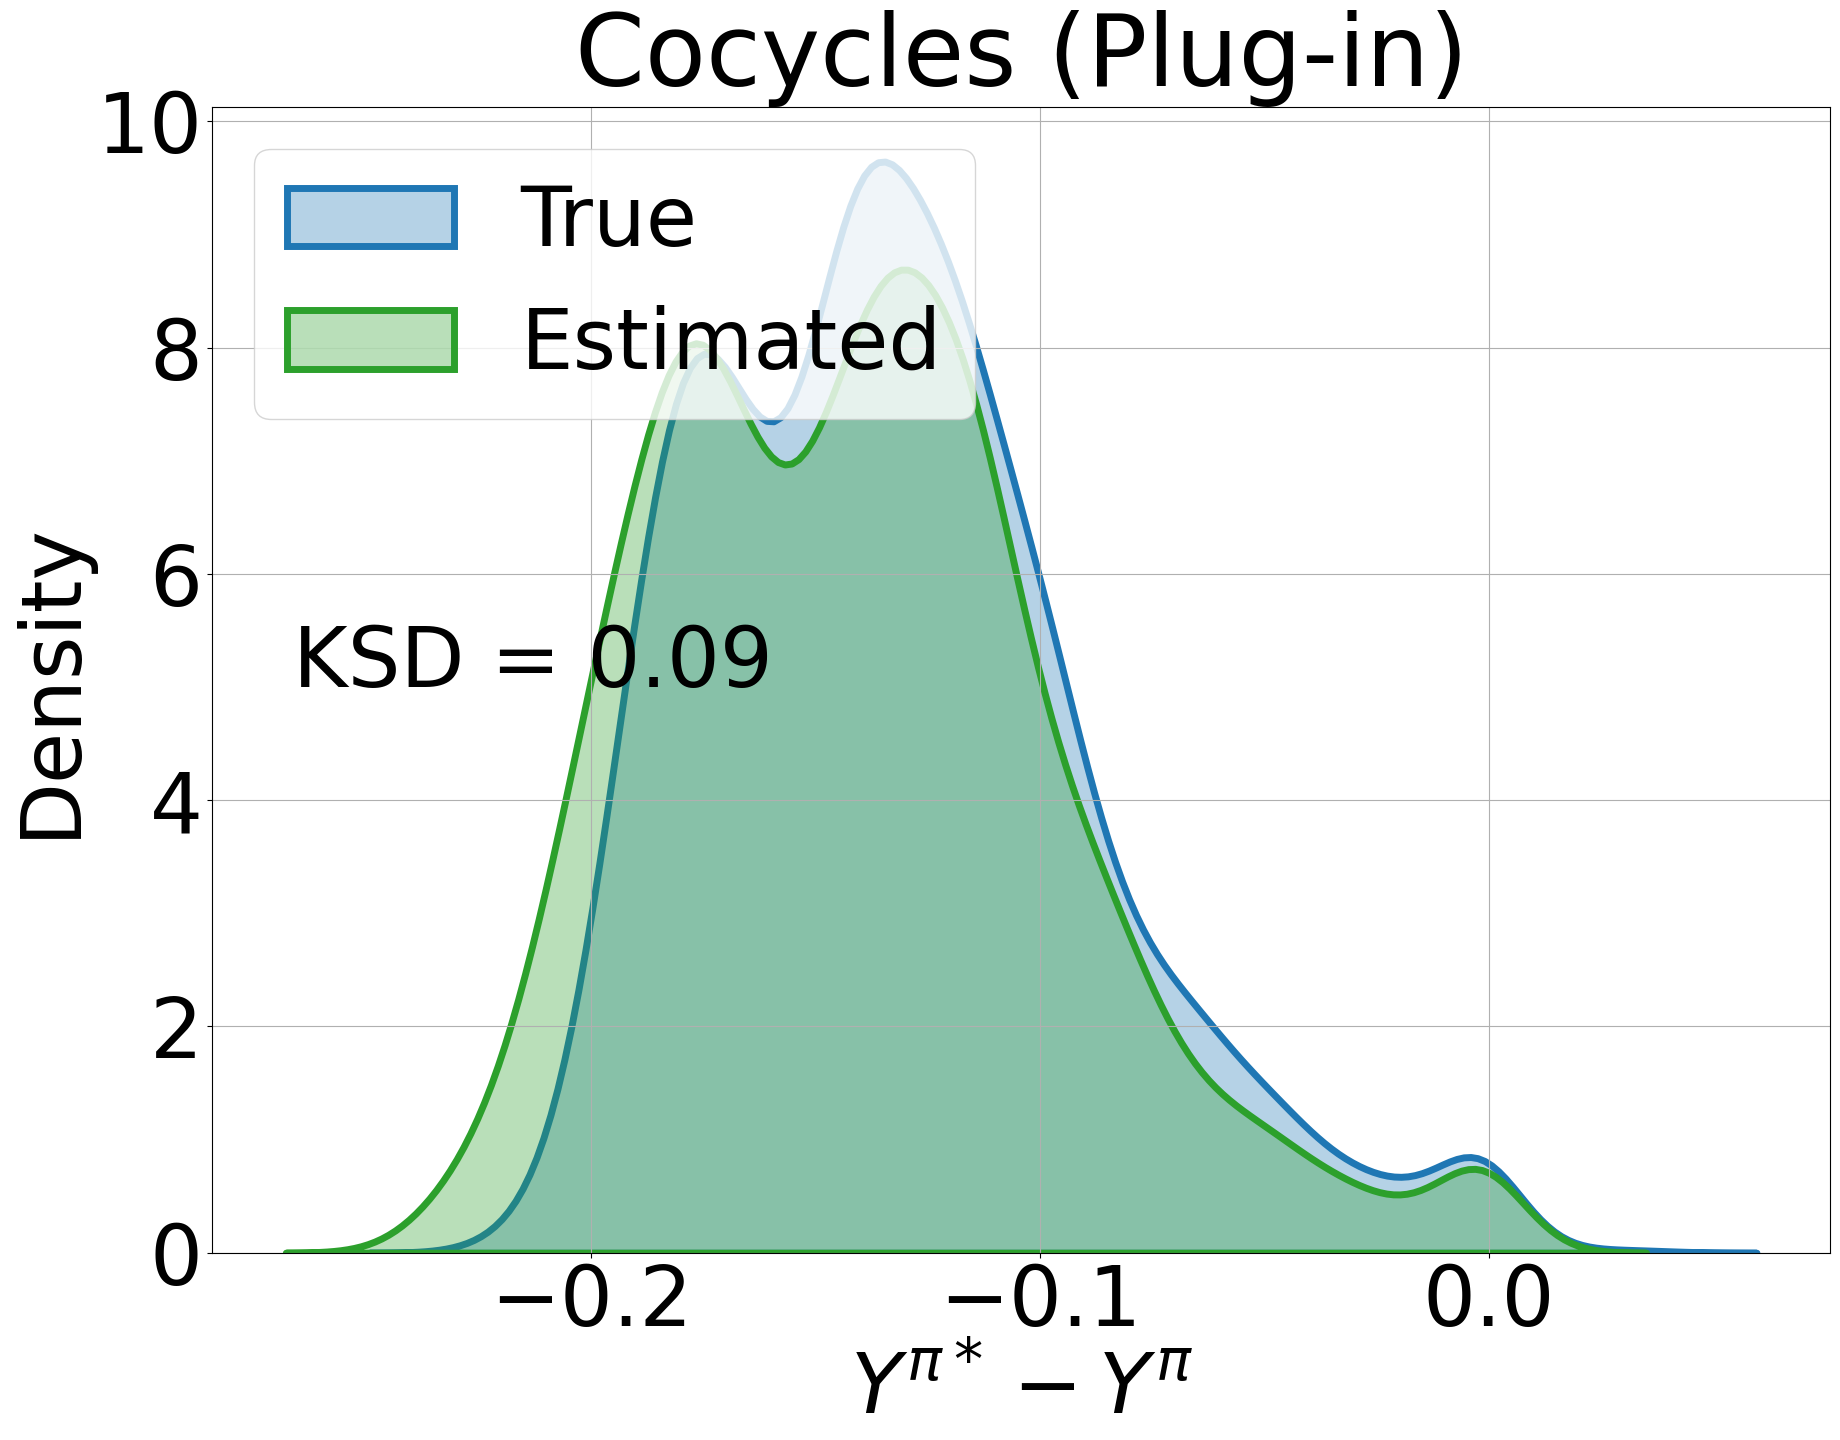

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Update matplotlib rcParams for higher font size and resolution
mpl.rcParams.update({
    'font.size': 60,         # Increase font size (default is usually 10)
    'figure.figsize': (20,16),  # Figure size remains the same as before
    'figure.dpi': 100        # Higher DPI for better fidelity
})

# Compute the KSD values
KSD = kolmogorov_distance(counterfactual_diffs, counterfactual_diffpreds)
KSDsplit = kolmogorov_distance(counterfactual_diffs, counterfactual_diffpreds_split)

# First plot: Sample-splitting based estimator
fig, ax = plt.subplots()
sns.kdeplot(counterfactual_diffs[:, 0], alpha=0.33, fill=True, ax=ax, label="True", lw = 5)
sns.kdeplot(counterfactual_diffpreds_split[:, 0], alpha=0.33, fill=True, ax=ax, label="Estimated", color = "C2", lw = 5)
ax.set_title("Cocycles (Sample-splitting)")
plt.xlabel(r"$Y^{\pi*} - Y^\pi$")
ax.legend()
# Add KSD label in the upper left corner of the plot area
ax.text(0.05, 0.55, f"KSD = {KSDsplit:.2f}", transform=ax.transAxes, verticalalignment='top')
ax.legend(loc = "upper left")
plt.grid(True)
plt.tight_layout()
fig.savefig("Cocycle_BD_counterfactual_dist_split", bbox_inches = "tight")
plt.show()

# Second plot: Plug-in based estimator
fig, ax = plt.subplots()
sns.kdeplot(counterfactual_diffs[:, 0], alpha=0.33, fill=True, ax=ax, label="True", lw = 5)
sns.kdeplot(counterfactual_diffpreds[:, 0], alpha=0.33, fill=True, ax=ax, label="Estimated", color = "C2", lw = 5)
ax.set_title("Cocycles (Plug-in)")
plt.xlabel(r"$Y^{\pi*} - Y^\pi$")
ax.legend(loc = "upper left")
# Add KSD label for the plug-in estimator
ax.text(0.05, 0.55, f"KSD = {KSD:.2f}", transform=ax.transAxes, verticalalignment='top')
plt.grid(True)
plt.tight_layout()
fig.savefig("Cocycle_BD_counterfactual_dist_pi", bbox_inches = "tight")
plt.show()

## Debug

In [6]:
# Extract predicted functions and true functions
shift_pred = final_model_overall.conditioner.layers[0]
scale_pred = final_model_overall.conditioner.layers[1]
from BD import shift, scale

In [12]:
# Get test points
from torch.distributions import Normal
ntest = 1000
Ztest = Normal(0,1).sample((1000, dgp_config['D']))
Xtest = torch.column_stack((policy(Ztest),Ztest))

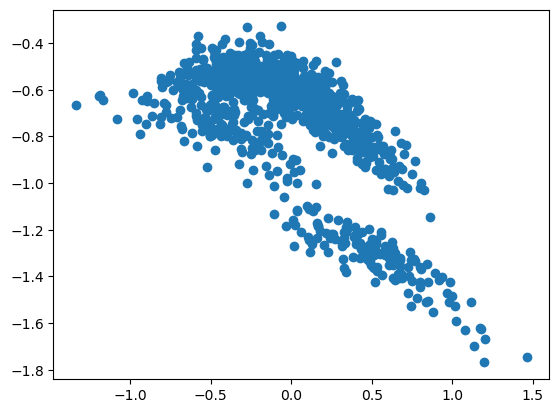

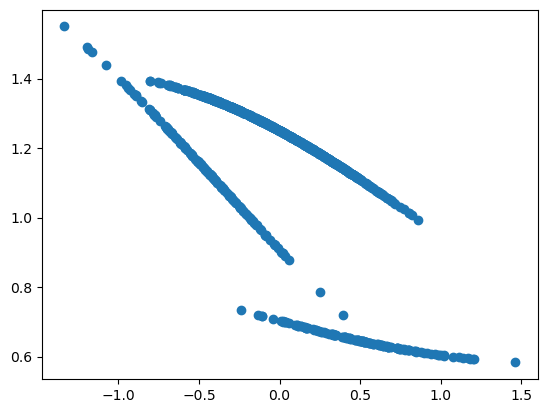

In [23]:
plt.scatter(Ztest @  dgp_config['projection_coeffs'], shift_pred(Xtest).detach())
plt.show()
plt.scatter(Ztest @ dgp_config['projection_coeffs'], shift(Ztest,policy, dgp_config['projection_coeffs']).detach())

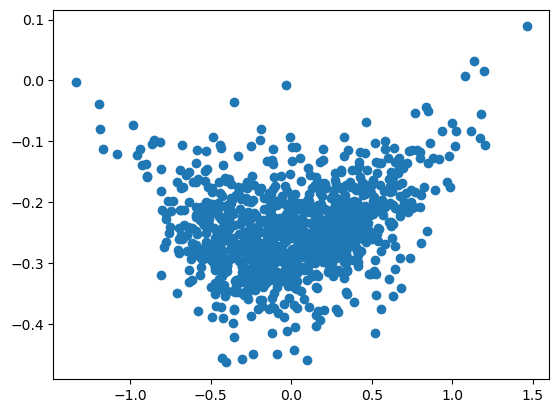

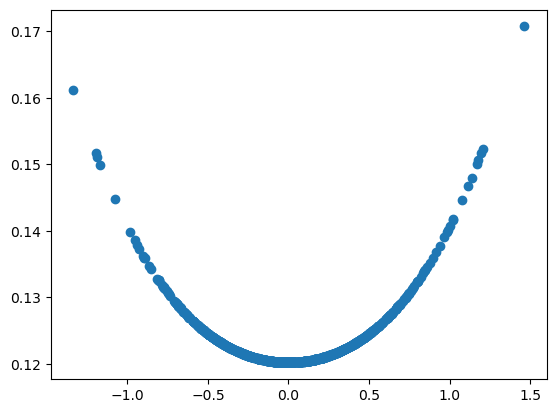

In [27]:
plt.scatter(Ztest @  dgp_config['projection_coeffs'], scale_pred(Xtest).detach())
plt.show()
plt.scatter(Ztest @ dgp_config['projection_coeffs'], scale(Ztest,dgp_config['projection_coeffs']).detach())